In [1]:
# Imported libraries
library(tidyverse)
library(caret)
library(rpart)
library(e1071) # pruning
library(pROC)
theme_set(theme_classic())
library(GGally)
library(FactoMineR)
library(factoextra)
library(MASS)
library(ROSE)
library(ggplot2)
library(plotly)
library(magrittr)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'stringr' was built under R version 3.6.3"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
# Loading of the data
PimaIndiansDiabetes2 = read_csv("diabetes_pima.csv") # reclassed 1,0 to pos, neg
pima.data = na.omit(PimaIndiansDiabetes2) # removing NAs (missing values)

# Inspecting the data
sample_n(pima.data, 5)


-- Column specification --------------------------------------------------------
cols(
  Pregnancies = col_double(),
  Glucose = col_double(),
  BloodPressure = col_double(),
  SkinThickness = col_double(),
  Insulin = col_double(),
  BMI = col_double(),
  DiabetesPedigreeFunction = col_double(),
  Age = col_double(),
  Outcome = col_character()
)




Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,123,62,0,0,32.0,0.226,35,pos
8,107,80,0,0,24.6,0.856,34,neg
3,107,62,13,48,22.9,0.678,23,pos
2,101,58,35,90,21.8,0.155,22,neg
3,111,56,39,0,30.1,0.557,30,neg


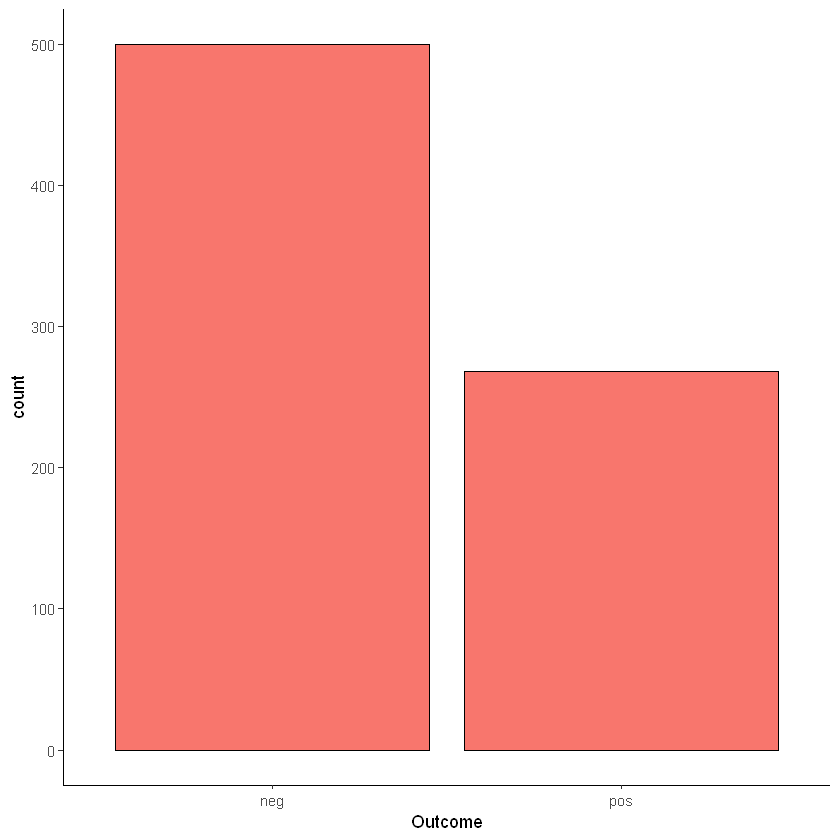

In [3]:
g = ggplot(pima.data, aes(Outcome, fill="red"))
g + geom_bar(colour="black") +
    guides(fill=FALSE)

In [4]:
# Dealing with imbalanced data
table(pima.data$Outcome)

# classes distribution
prop.table(table(pima.data$Outcome))

# shows a slight imbalance which could affect prediction accuracy


pima.data_balanced_both = ovun.sample(Outcome ~ ., data = pima.data, method = "both", p=0.5, N=768, seed = 1)$data
table(pima.data_balanced_both$Outcome)

pima.data_balanced = ROSE(Outcome ~ ., data = pima.data, seed = 1)$data
table(pima.data_balanced$Outcome)

# new class distribution
prop.table(table(pima.data_balanced_both$Outcome))


neg pos 
500 268 


      neg       pos 
0.6510417 0.3489583 


neg pos 
396 372 


neg pos 
396 372 


     neg      pos 
0.515625 0.484375 

# Splitting the data

In [5]:
pima.data_balanced_both$Outcome %<>% factor # identifies Outcome feature as binary 

sample_n(pima.data_balanced_both, 5)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,124,60,32,0,35.8,0.514,21,neg
0,162,76,36,0,49.6,0.364,26,pos
3,139,54,0,0,25.6,0.402,22,pos
11,138,74,26,144,36.1,0.557,50,pos
10,148,84,48,237,37.6,1.001,51,pos


In [6]:
set.seed(123)
training.samples = pima.data_balanced_both$Outcome %>%
    createDataPartition(p = 0.8, list = FALSE) # 80% for building a predictive model and test set 20% for evaluating the model
train.data = pima.data_balanced_both[training.samples, ]
test.data = pima.data_balanced_both[-training.samples, ]

sample_n(pima.data_balanced_both, 10) # sample of dataset

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,110,66,0,0,31.9,0.471,29,neg
2,174,88,37,120,44.5,0.646,24,pos
0,141,84,26,0,32.4,0.433,22,neg
7,100,0,0,0,30.0,0.484,32,pos
7,196,90,0,0,39.8,0.451,41,pos
5,124,74,0,0,34.0,0.220,38,pos
4,95,64,0,0,32.0,0.161,31,pos
0,101,62,0,0,21.9,0.336,25,neg
7,160,54,32,175,30.5,0.588,39,pos
4,118,70,0,0,44.5,0.904,26,neg


# Stepwise Logistic Regression

In [7]:
full.model = glm(Outcome ~., data = train.data, family = binomial)
coef(full.model) # logistic regression model produced, showing coefficients
summary(full.model)

(Intercept)              Pregnancies                  Glucose 
           -8.1555355867             0.1846031036             0.0345190387 
           BloodPressure            SkinThickness                  Insulin 
           -0.0150304029            -0.0007317493            -0.0001131895 
                     BMI DiabetesPedigreeFunction                      Age 
            0.0940235084             1.2900672011             0.0112007230


Call:
glm(formula = Outcome ~ ., family = binomial, data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8628  -0.7692  -0.2679   0.7735   2.4315  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -8.1555356  0.7856211 -10.381  < 2e-16 ***
Pregnancies               0.1846031  0.0367799   5.019 5.19e-07 ***
Glucose                   0.0345190  0.0041641   8.290  < 2e-16 ***
BloodPressure            -0.0150304  0.0058920  -2.551 0.010742 *  
SkinThickness            -0.0007317  0.0079250  -0.092 0.926432    
Insulin                  -0.0001132  0.0010376  -0.109 0.913135    
BMI                       0.0940235  0.0156421   6.011 1.84e-09 ***
DiabetesPedigreeFunction  1.2900672  0.3642532   3.542 0.000398 ***
Age                       0.0112007  0.0105724   1.059 0.289404    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to 

In [8]:
# Make predictions
probabilities = full.model %>% predict(test.data, type = "response")
predicted.classes = ifelse(probabilities > 0.5, "pos", "neg")
# Model accuracy
mean(predicted.classes==test.data$Outcome)

[1] 0.751634

In [9]:
step.model = full.model %>% stepAIC(trace = FALSE)
coef(step.model) # new logistic regression model produced, showing coefficients
summary(step.model)

(Intercept)              Pregnancies                  Glucose 
             -7.96838889               0.20439373               0.03517442 
           BloodPressure                      BMI DiabetesPedigreeFunction 
             -0.01427869               0.09273656               1.28612419


Call:
glm(formula = Outcome ~ Pregnancies + Glucose + BloodPressure + 
    BMI + DiabetesPedigreeFunction, family = binomial, data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8402  -0.7819  -0.2658   0.7826   2.4726  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -7.968389   0.757820 -10.515  < 2e-16 ***
Pregnancies               0.204394   0.032401   6.308 2.82e-10 ***
Glucose                   0.035174   0.003840   9.160  < 2e-16 ***
BloodPressure            -0.014279   0.005777  -2.472 0.013449 *  
BMI                       0.092737   0.014720   6.300 2.97e-10 ***
DiabetesPedigreeFunction  1.286124   0.357574   3.597 0.000322 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 851.98  on 614  degrees of freedom
Residual deviance: 594.77  on 609  degrees of freedom
AIC: 606.77

Number of

In [10]:
# predictions
probabilities = predict(step.model, test.data, type = "response")
predicted.classes = ifelse(probabilities > 0.5, "pos", "neg")
# Prediction accuracy
observed.classes = test.data$Outcome
mean(predicted.classes == observed.classes)

[1] 0.7581699

# Splitting new dataset

In [11]:
# creating new dataset with reduced features and splitting the new dataset
pima.data_stepwise = dplyr::select(pima.data_balanced_both, -SkinThickness, -Age, -Insulin) # removing features
pima.data_stepwise$Outcome %<>% factor # identifies Outcome feature as binary 
sample_n(pima.data_stepwise, 3) # sample of dataset with less features

# Split the reduced feature dataset into training and test set
set.seed(123)
training.samples = pima.data_stepwise$Outcome %>%
    createDataPartition(p = 0.8, list = FALSE)
train.data = pima.data_stepwise[training.samples, ]
test.data = pima.data_stepwise[-training.samples, ]

# Estimate preprocessing parameters
preproc.param = train.data %>% 
  preProcess(method = c("center", "scale")) # scaling standardisation

# Transform the data using the estimated parameters
train.transformed = preproc.param %>% predict(train.data)
test.transformed = preproc.param %>% predict(test.data)

Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Outcome
5,116,74,32.3,0.660,pos
1,109,58,28.5,0.219,neg
3,124,80,33.2,0.305,neg


# LDA

In [12]:
# fit the LDA model on the training set and make predictions on the test data
library(MASS)
# Fit LDA
fit = lda(Outcome ~., data = train.transformed)

# Make predictions on the test data
predictions = predict(fit, test.transformed)
prediction.probabilities = predictions$posterior[,2]
predicted.classes = predictions$class
observed.classes = test.transformed$Outcome

# accuracy
accuracy = mean(observed.classes == predicted.classes)
accuracy

error = mean(observed.classes != predicted.classes)
error

fit

[1] 0.7581699

[1] 0.2418301

Call:
lda(Outcome ~ ., data = train.transformed)

Prior probabilities of groups:
      neg       pos 
0.5154472 0.4845528 

Group means:
    Pregnancies    Glucose BloodPressure        BMI DiabetesPedigreeFunction
neg  -0.2856646 -0.4607561    -0.0976155 -0.3106688               -0.1901460
pos   0.3038781  0.4901332     0.1038393  0.3304765                0.2022695

Coefficients of linear discriminants:
                                LD1
Pregnancies               0.4991982
Glucose                   0.8103430
BloodPressure            -0.1835803
BMI                       0.5117278
DiabetesPedigreeFunction  0.2451869

In [13]:
# confusion matrix

# Confusion matrix, number of cases
table(observed.classes, predicted.classes)

# Confusion matrix, proportion of cases
table(observed.classes, predicted.classes) %>%
prop.table() %>% round(digits = 3)

confusionMatrix(predicted.classes,as.factor(observed.classes))

                predicted.classes
observed.classes neg pos
             neg  69  10
             pos  27  47

                predicted.classes
observed.classes   neg   pos
             neg 0.451 0.065
             pos 0.176 0.307

Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg  69  27
       pos  10  47
                                          
               Accuracy : 0.7582          
                 95% CI : (0.6824, 0.8237)
    No Information Rate : 0.5163          
    P-Value [Acc > NIR] : 6.867e-10       
                                          
                  Kappa : 0.5123          
                                          
 Mcnemar's Test P-Value : 0.008529        
                                          
            Sensitivity : 0.8734          
            Specificity : 0.6351          
         Pos Pred Value : 0.7188          
         Neg Pred Value : 0.8246          
             Prevalence : 0.5163          
         Detection Rate : 0.4510          
   Detection Prevalence : 0.6275          
      Balanced Accuracy : 0.7543          
                                          
       'Positive' Class : neg             
                              

Setting levels: control = neg, case = pos

Setting direction: controls < cases

Warning message:
"`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


thresholds,sensitivity,specificity
0.3012987,0.7972973,0.6075949
0.3036795,0.7837838,0.6075949
0.3055761,0.7837838,0.6202532
0.3074062,0.7837838,0.6455696
0.3109096,0.7837838,0.6582278
0.3178498,0.7837838,0.6708861
0.3232483,0.7837838,0.6835443
0.3288257,0.7837838,0.6962025
0.3335854,0.7702703,0.6962025
0.3346967,0.7702703,0.7088608


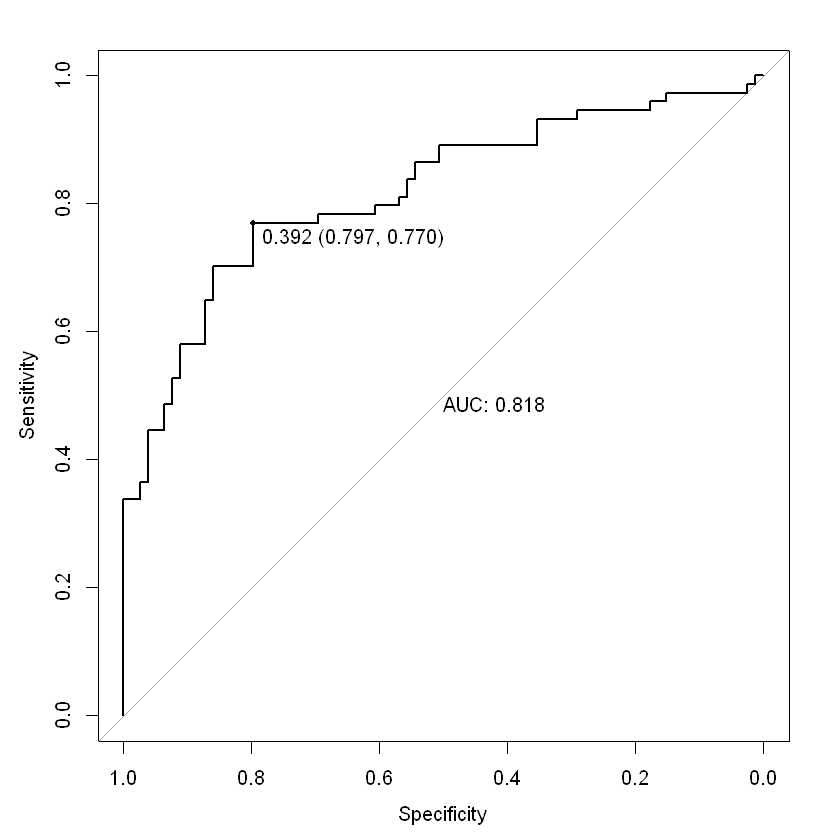

In [14]:
# ROC Curve
res.roc = roc(observed.classes, prediction.probabilities)

# Extracting results
roc.data = data_frame(
thresholds = res.roc$thresholds,
sensitivity = res.roc$sensitivities,
specificity = res.roc$specificities
)
# Get the probability threshold for specificity = 0.6
roc.data %>% filter(specificity >= 0.6)

# plot with best threshold with the highest sum sensitivity + specificity
plot.roc(res.roc, print.auc = TRUE, print.thres = "best")

# Decision Tree

cp
0.01342282


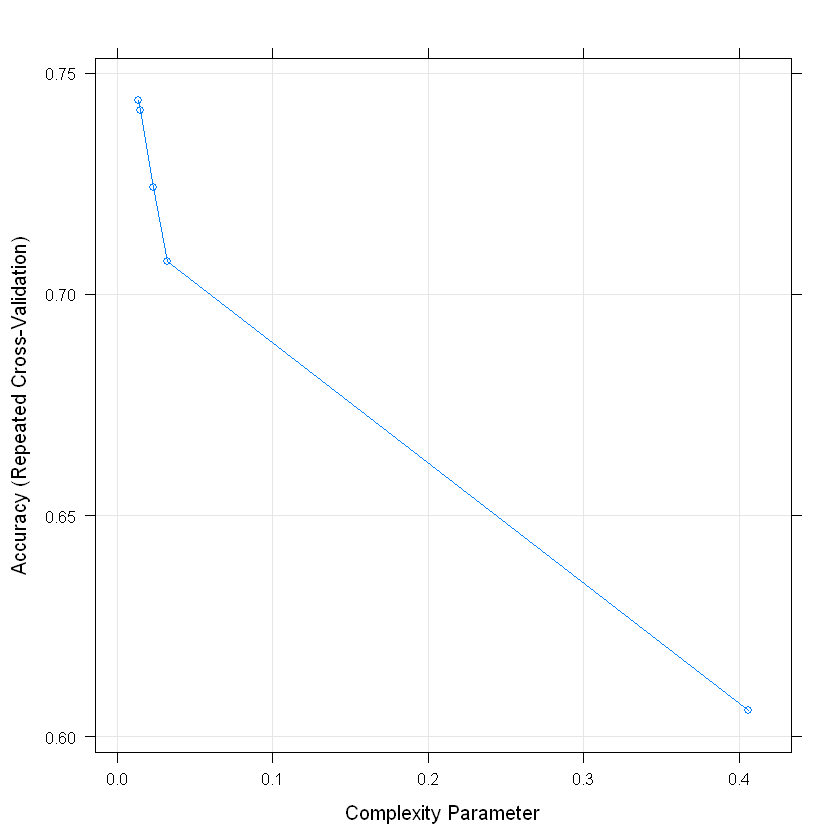

n= 615 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 615 298 neg (0.51544715 0.48455285)  
   2) Glucose< 0.4519475 422 141 neg (0.66587678 0.33412322)  
     4) BMI< -0.7997321 102   5 neg (0.95098039 0.04901961) *
     5) BMI>=-0.7997321 320 136 neg (0.57500000 0.42500000)  
      10) Glucose< -1.008912 67  10 neg (0.85074627 0.14925373) *
      11) Glucose>=-1.008912 253 126 neg (0.50197628 0.49802372)  
        22) Pregnancies< 0.1338341 152  61 neg (0.59868421 0.40131579)  
          44) DiabetesPedigreeFunction< 2.11025 145  54 neg (0.62758621 0.37241379) *
          45) DiabetesPedigreeFunction>=2.11025 7   0 pos (0.00000000 1.00000000) *
        23) Pregnancies>=0.1338341 101  36 pos (0.35643564 0.64356436)  
          46) DiabetesPedigreeFunction< 0.2922951 70  34 neg (0.51428571 0.48571429)  
            92) BMI< 0.7505372 63  27 neg (0.57142857 0.42857143) *
            93) BMI>=0.7505372 7   0 pos (0.00000000 1.00000000) *
          47) Diab

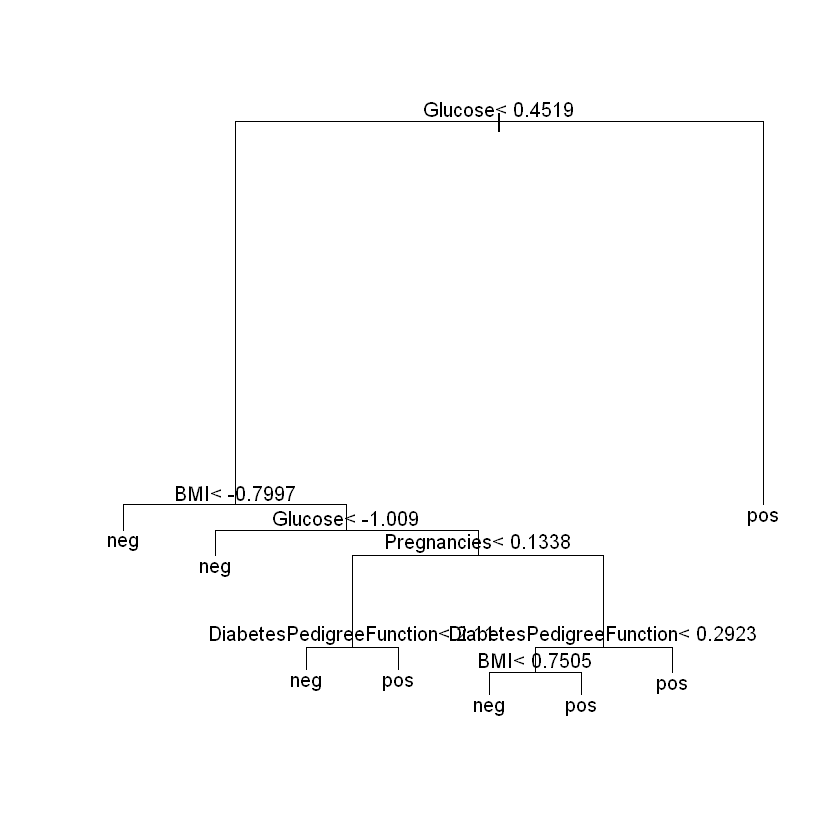

In [15]:
# Pruned model

set.seed(123)
model2 = train(
Outcome ~., data = train.transformed, method = "rpart",
    # (Stackoverflow, 2017)
trControl = trainControl("repeatedcv", number = 10, repeats = 3), # to set up 10-fold cross validation
tuneLength = 5) # specifies number of possible cp values to look at. 
# Complexity parameter (cp) places a penalty when there are too many splits in the tree


# Plot model accuracy vs different cp's (complexity parameters)
plot(model2)

# optimal tuning parameter cp that maximises the cross-validation accuracy
model2$bestTune

# Plotting of final tree model
par(xpd = NA) # Avoid clipping the text in some device
plot(model2$finalModel)
text(model2$finalModel, digits = 3)

# fully grown tree showing all predictor variables in the data set.

# Decision rules in the model
model2$finalModel

In [16]:
observed.classes = test.transformed$Outcome

# Predictions on test data
predicted.classes = model2 %>% predict(test.transformed)

# Accuracy
mean(predicted.classes == test.transformed$Outcome)

# Error
error = mean(observed.classes != predicted.classes)
error

[1] 0.7058824

[1] 0.2941176

In [17]:
# Confusion matrix, number of cases
table(observed.classes, predicted.classes)

# Confusion matrix, proportion of cases
table(observed.classes, predicted.classes) %>%
prop.table() %>% round(digits = 3)

confusionMatrix(predicted.classes,as.factor(observed.classes))
# (Stackoverflow, 2015)

                predicted.classes
observed.classes neg pos
             neg  72   7
             pos  38  36

                predicted.classes
observed.classes   neg   pos
             neg 0.471 0.046
             pos 0.248 0.235

Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg  72  38
       pos   7  36
                                          
               Accuracy : 0.7059          
                 95% CI : (0.6269, 0.7767)
    No Information Rate : 0.5163          
    P-Value [Acc > NIR] : 1.408e-06       
                                          
                  Kappa : 0.4032          
                                          
 Mcnemar's Test P-Value : 7.744e-06       
                                          
            Sensitivity : 0.9114          
            Specificity : 0.4865          
         Pos Pred Value : 0.6545          
         Neg Pred Value : 0.8372          
             Prevalence : 0.5163          
         Detection Rate : 0.4706          
   Detection Prevalence : 0.7190          
      Balanced Accuracy : 0.6989          
                                          
       'Positive' Class : neg             
                              

Setting levels: control = neg, case = pos

Setting direction: controls < cases



thresholds,sensitivity,specificity
1.5,0.4864865,0.9113924
Inf,0.0000000,1.0000000


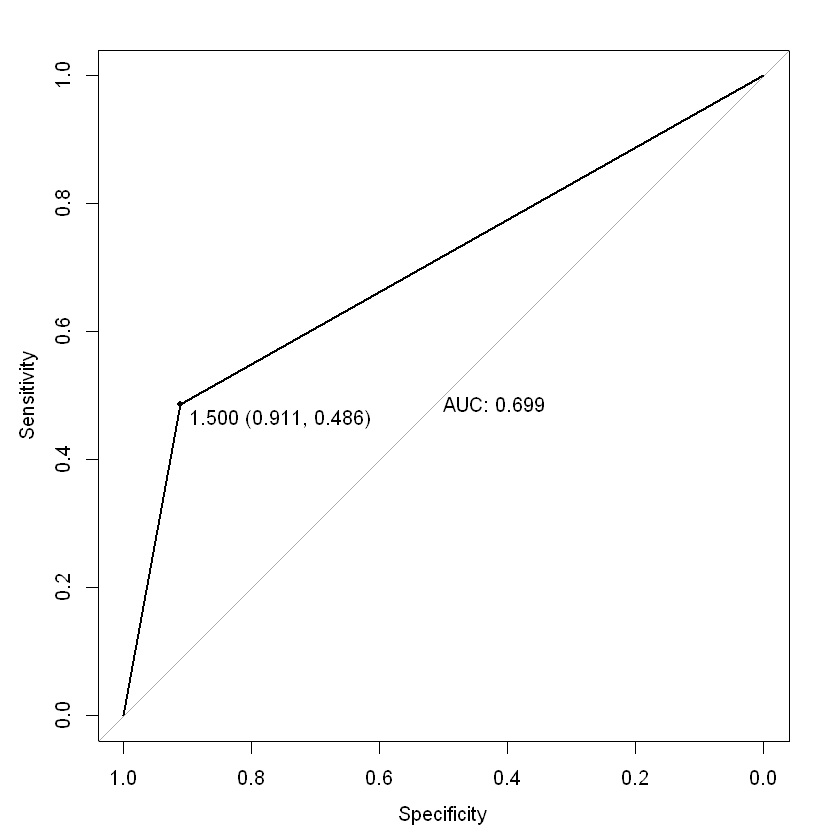

In [18]:
# Compute roc for roc curve
res.roc = roc(observed.classes, as.numeric(predicted.classes))

# extract results
roc.data = data_frame(
thresholds = res.roc$thresholds,
sensitivity = res.roc$sensitivities,
specificity = res.roc$specificities
)
# Get the probability threshold for specificity = 0.6
roc.data %>% filter(specificity >= 0.6)

# plot of best threshold with the highest sum sensitivity + specificity
plot.roc(res.roc, print.auc = TRUE, print.thres = "best")

# Random Forest (Ensemble)

In [19]:
# Fit model on training set
set.seed(123)
model = train(
Outcome ~., data = train.transformed, method = "rf",
trControl = trainControl("cv", number = 10),
importance = TRUE, 
preProcess = c("center","scale"))

# Best tuning parameter
model$bestTune

mtry
2


In [20]:
# Final model
model$finalModel


Call:
 randomForest(x = x, y = y, mtry = param$mtry, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 11.22%
Confusion matrix:
    neg pos class.error
neg 280  37   0.1167192
pos  32 266   0.1073826

In [21]:
# Predictions on the test data
predicted.classes = model %>% predict(test.transformed)
head(predicted.classes)

# Accuracy rate
mean(predicted.classes == test.transformed$Outcome)

[1] neg neg neg neg neg neg
Levels: neg pos

[1] 0.9019608

In [22]:
observed.classes = test.transformed$Outcome

# Confusion matrix, number of cases
table(observed.classes, predicted.classes)

# Confusion matrix, proportion of cases
table(observed.classes, predicted.classes) %>%
prop.table() %>% round(digits = 3)

confusionMatrix(predicted.classes,as.factor(observed.classes))

                predicted.classes
observed.classes neg pos
             neg  74   5
             pos  10  64

                predicted.classes
observed.classes   neg   pos
             neg 0.484 0.033
             pos 0.065 0.418

Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg  74  10
       pos   5  64
                                          
               Accuracy : 0.902           
                 95% CI : (0.8435, 0.9441)
    No Information Rate : 0.5163          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8033          
                                          
 Mcnemar's Test P-Value : 0.3017          
                                          
            Sensitivity : 0.9367          
            Specificity : 0.8649          
         Pos Pred Value : 0.8810          
         Neg Pred Value : 0.9275          
             Prevalence : 0.5163          
         Detection Rate : 0.4837          
   Detection Prevalence : 0.5490          
      Balanced Accuracy : 0.9008          
                                          
       'Positive' Class : neg             
                              

Setting levels: control = neg, case = pos

Setting direction: controls < cases



thresholds,sensitivity,specificity
1.5,0.8648649,0.9367089
Inf,0.0000000,1.0000000


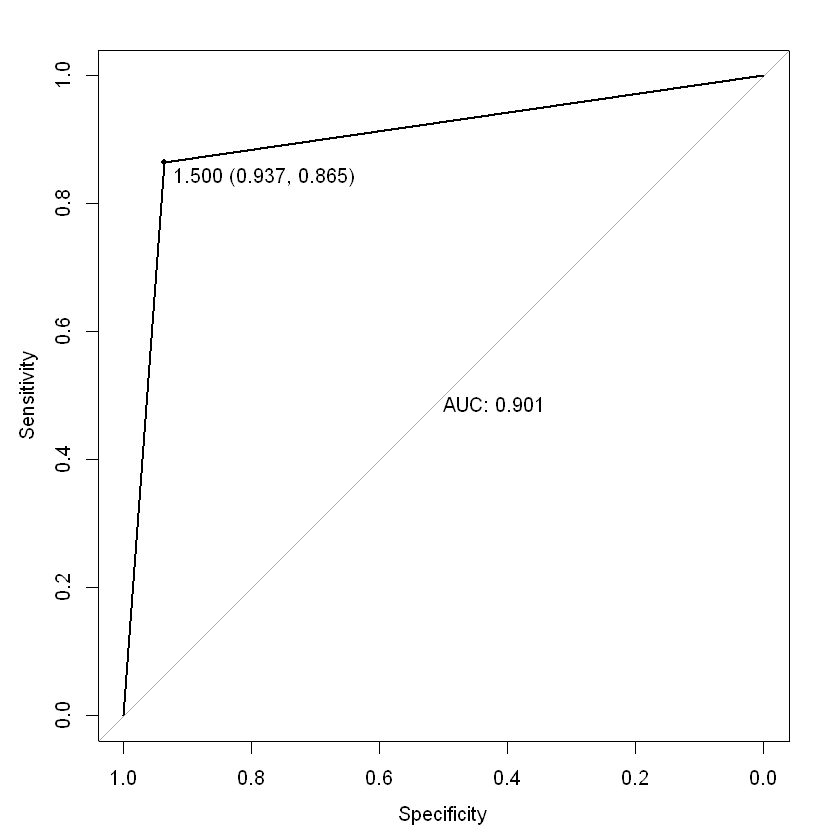

In [23]:
# Compute roc for roc curve

res.roc = roc(observed.classes, as.numeric(predicted.classes))

# Extract results
roc.data = data_frame(
thresholds = res.roc$thresholds,
sensitivity = res.roc$sensitivities,
specificity = res.roc$specificities
)
# {robability threshold for specificity = 0.6
roc.data %>% filter(specificity >= 0.6)

# plot of best threshold with the highest sum sensitivity + specificity
plot.roc(res.roc, print.auc = TRUE, print.thres = "best")

# kNN

,k
11,25


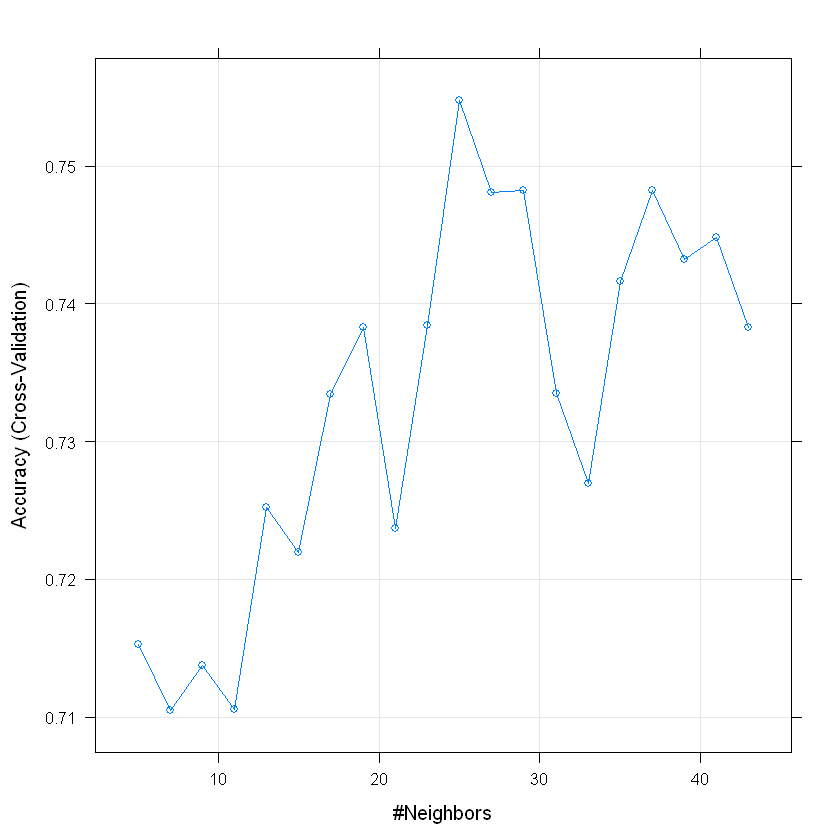

In [24]:
# Fit the model on the training set
set.seed(123)
model = train(
Outcome ~., data = train.transformed, method = "knn",
trControl = trainControl("cv", number = 10),
preProcess = c("center","scale"), # to normalise the data
tuneLength = 20
)

# Plot model accuracy vs different k values
plot(model)

# Printing the optimal tuning parameter k that maximizes model accuracy
model$bestTune

In [25]:
# Predictions on  test data
predicted.classes = model %>% predict(test.transformed)
head(predicted.classes)

# Accuracy
mean(predicted.classes == test.transformed$Outcome)

[1] neg pos neg neg neg neg
Levels: neg pos

[1] 0.7189542

In [26]:
observed.classes = test.transformed$Outcome

# Confusion matrix, number of cases
table(observed.classes, predicted.classes)

# Confusion matrix, proportion of cases
table(observed.classes, predicted.classes) %>%
prop.table() %>% round(digits = 3)

confusionMatrix(predicted.classes,as.factor(observed.classes))

                predicted.classes
observed.classes neg pos
             neg  63  16
             pos  27  47

                predicted.classes
observed.classes   neg   pos
             neg 0.412 0.105
             pos 0.176 0.307

Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg  63  27
       pos  16  47
                                          
               Accuracy : 0.719           
                 95% CI : (0.6407, 0.7886)
    No Information Rate : 0.5163          
    P-Value [Acc > NIR] : 2.535e-07       
                                          
                  Kappa : 0.4346          
                                          
 Mcnemar's Test P-Value : 0.1273          
                                          
            Sensitivity : 0.7975          
            Specificity : 0.6351          
         Pos Pred Value : 0.7000          
         Neg Pred Value : 0.7460          
             Prevalence : 0.5163          
         Detection Rate : 0.4118          
   Detection Prevalence : 0.5882          
      Balanced Accuracy : 0.7163          
                                          
       'Positive' Class : neg             
                              

Setting levels: control = neg, case = pos

Setting direction: controls < cases



thresholds,sensitivity,specificity
1.5,0.6351351,0.7974684
Inf,0.0000000,1.0000000


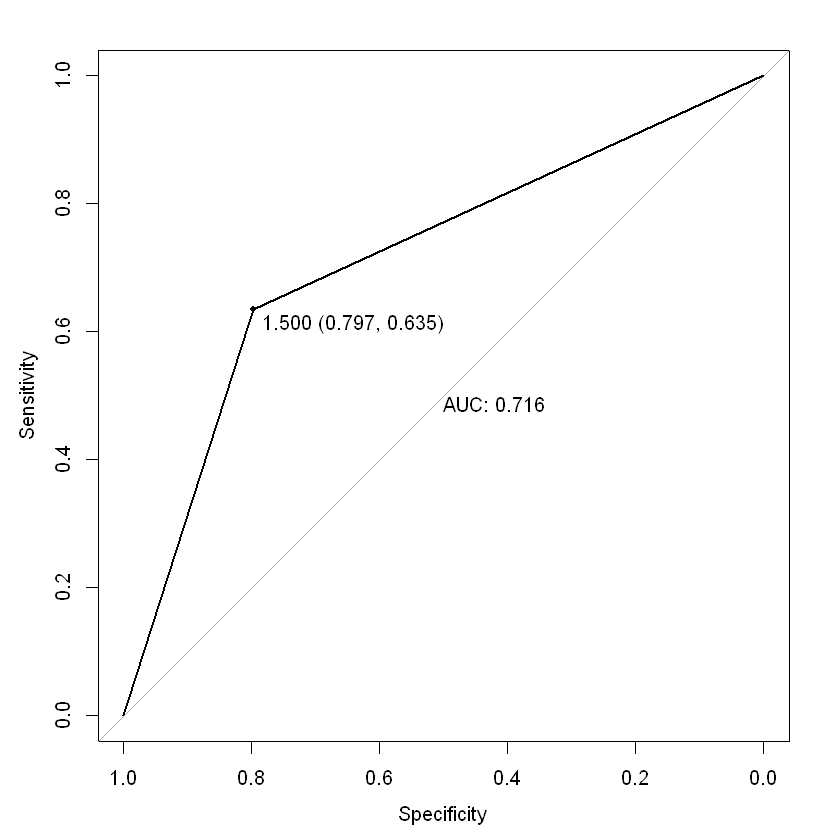

In [27]:
# Computing roc

res.roc = roc(observed.classes, as.numeric(predicted.classes))

# Extracting results
roc.data = data_frame(
thresholds = res.roc$thresholds,
sensitivity = res.roc$sensitivities,
specificity = res.roc$specificities
)
# Probability threshold for specificity = 0.6
roc.data %>% filter(specificity >= 0.6)

# plot of best threshold with the highest sum sensitivity + specificity
plot.roc(res.roc, print.auc = TRUE, print.thres = "best")